In [3]:
# Importing Basic Libraries
import os
import pandas as pd
from pathlib import Path
import csv
import numpy as np

In [4]:
# Importing Libraries for Optimal Portfolio Creation and Monte Carlo
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from mc_data_mess1 import MC_Df_Simulation

In [5]:
# Importing Libraries for Dashboard Creation
import panel as pn
import hvplot.pandas
import ipywidgets as widgets

In [6]:
# Reading in daily prices dataframe containing one year of stock data from Gold, SP500, BTC, VNQ (real estate etf), and FAANG (a combination of tech stocks: Facebook, Apple, Amazon, Netflix, Google)

filepath = ("../data/csv_files/CLEAN_CSV_Project.csv")

df = pd.read_csv(filepath)

assets = df.set_index("Date")

pct_change = assets.pct_change().dropna()

In [7]:
# Creating widgets to allow user to interact with creating their on portfolio based on their allocation of weights

wGLD = widgets.IntSlider(description="Gold", step=5, value=20)

wSNP = widgets.IntSlider(description="SNP500", step=5, value=20)

wVNQ = widgets.IntSlider(description="VNQ", step=5, value=20)

wBTC = widgets.IntSlider(description="BTC", step=5, value=20)

wFNG = widgets.IntSlider(description="FNG",step=5, value = 20)


display(wGLD, wSNP, wVNQ, wBTC, wFNG)

IntSlider(value=20, description='Gold', step=5)

IntSlider(value=20, description='SNP500', step=5)

IntSlider(value=20, description='VNQ', step=5)

IntSlider(value=20, description='BTC', step=5)

IntSlider(value=20, description='FNG', step=5)

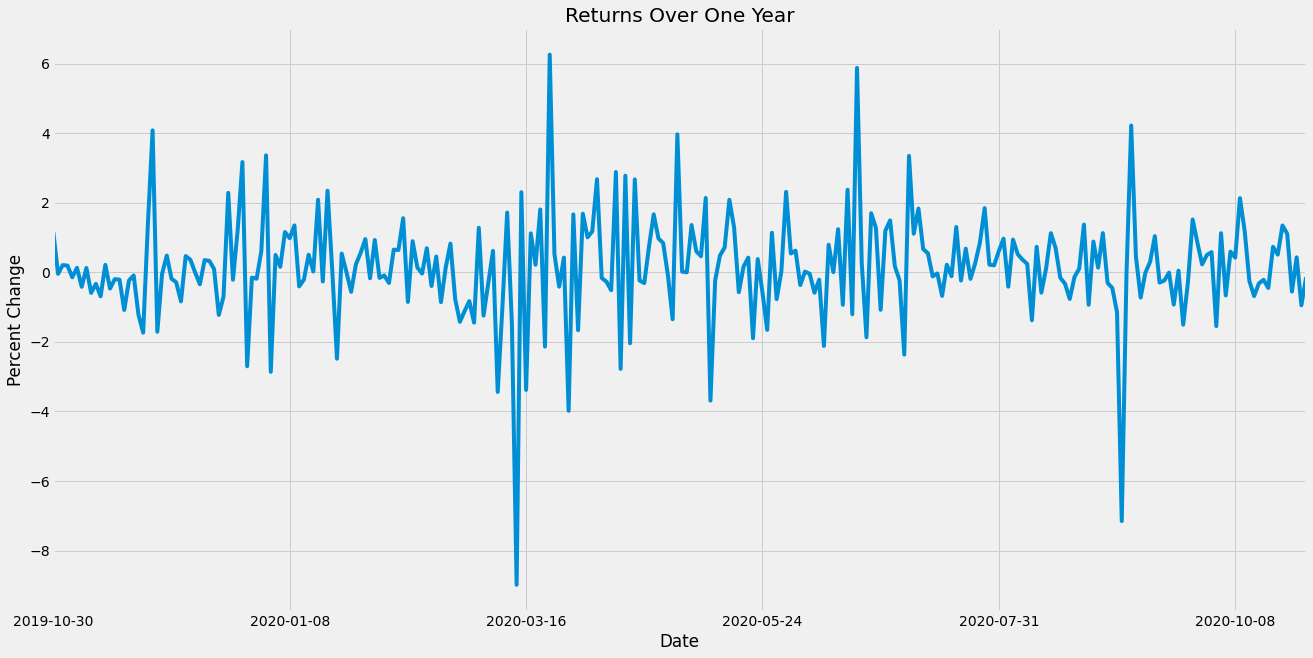

In [8]:
# Creating Plot that is linked to the widget interaction above

GLD = wGLD.value
SNP = wSNP.value
VNQ = wVNQ.value
BTC = wBTC.value
FNG= wFNG.value

if GLD + SNP + VNQ + BTC + FNG == 100:
    portfolio_weights = [GLD, SNP, VNQ, BTC, FNG]

    portfolio_return = pct_change.dot(portfolio_weights)

    plot = portfolio_return.plot(title = "Returns Over One Year", figsize = (20, 10))
    plot = plot.set_ylabel("Percent Change")
    plot
    #portfolio_return.hvplot()


else:
    print("Adjust your inputs. Total weight must equal 100")


In [9]:
# After allowing user to create their own best return, we created an optimized weighting using an efficient frontier analysis

assets_project = ["Gold", "sp500", "VNQ", "BITCOIN", "FAANG"]

In [10]:
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

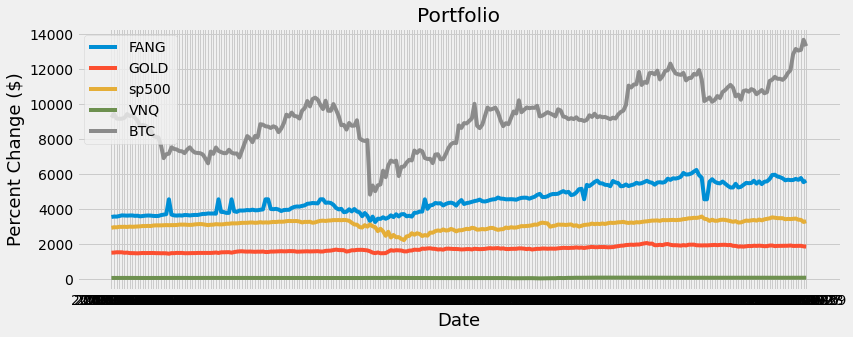

In [11]:
title = "Portfolio"
# created using the daily prices of all assets above
assets 
#Create and plot the graph
plt.figure(figsize=(12.2,4.5)) #width = 12.2in, height = 4.5
# Loop through each stock and plot the Adj Close for each day
for c in assets.columns.values:
  plt.plot( assets[c],  label=c)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)
plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Percent Change ($)',fontsize=18)
plt.legend(assets.columns.values, loc='upper left')
plt.show()

In [12]:
returns = assets.pct_change()

In [13]:
cov_matrix_annual = assets.cov() * 252
cov_matrix_annual

FANG          GOLD         sp500           VNQ           BTC
FANG   1.566919e+08  2.979589e+07  2.918407e+07  1.042869e+06  2.760244e+08
GOLD   2.979589e+07  6.776496e+06  4.258897e+06  2.026336e+05  5.263896e+07
sp500  2.918407e+07  4.258897e+06  1.638756e+07  2.886518e+05  7.480399e+07
VNQ    1.042869e+06  2.026336e+05  2.886518e+05  1.987938e+04  1.860034e+06
BTC    2.760244e+08  5.263896e+07  7.480399e+07  1.860034e+06  7.254176e+08

In [14]:
# Portfolio Variance
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

73819770.25764994

In [15]:
# Portfolio Volatility (aka STANDARD DEVIATION)
port_volatility = np.sqrt(port_variance)
port_volatility 

8591.843239820542

In [16]:
# Annual Return (raw return on investment)
portfolioSimpleAnnualReturn = np.sum(assets.mean()*weights) * 252
portfolioSimpleAnnualReturn

941186.0451235956

In [17]:
percent_var = str(round(port_variance, 2) * 100) + '%'
percent_vols = str(round(port_volatility, 2) * 100) + '%'
percent_ret = str(round(portfolioSimpleAnnualReturn, 2)*100)+'%'
print("Expected annual return : "+ percent_ret)
print('Annual volatility/standard deviation/risk : '+percent_vols)
print('Annual variance : '+percent_var)

Expected annual return : 94118605.0%
Annual volatility/standard deviation/risk : 859184.0%
Annual variance : 7381977026.000001%


In [18]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [19]:
mu = expected_returns.mean_historical_return(assets)
S = risk_models.sample_cov(assets)

In [20]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe() #Maximize the Sharpe ratio, and get the raw weights
cleaned_weights = ef.clean_weights() 
print(cleaned_weights) #Note the weights may have some rounding error, meaning they may not add up exactly to 1 but should be close
ef.portfolio_performance(verbose=True)

OrderedDict([('FANG', 0.13135), ('GOLD', 0.57923), ('sp500', 0.16066), ('VNQ', 0.08552), ('BTC', 0.04323)])
Expected annual return: 24.7%
Annual volatility: 16.4%
Sharpe Ratio: 1.39


(0.24689286554839024, 0.16351786248450942, 1.387572355099031)

In [21]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
latest_prices = get_latest_prices(assets)
weights = cleaned_weights 
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=150000)
allocation, leftover = da.lp_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'FANG': 4, 'GOLD': 47, 'sp500': 8, 'VNQ': 137}
Funds remaining: $268.28


In [22]:
# Using the allocation from the efficient frontier analysis, we are going to make a monte carlo projection for the next 5 years

In [23]:
# Bringing in Weights From Optimized Portfolio

fang = .13135
gold = .57923
sp500 = .16066
vnq = .08552
btc = .04323

In [24]:
simulation = MC_Df_Simulation(
    portfolio_data = assets,
    weights = [fang, gold, sp500, vnq, btc],
    num_simulation = 100,
    num_trading_days = 252*5
)
simulation.portfolio_data.head()

FANG    GOLD    sp500    VNQ      BTC
Date                                                
2019-10-29  3554.71  1520.6  2938.13  80.98  9218.76
2019-10-30  3581.21  1526.5  2970.27  81.98  9433.35
2019-10-31  3576.71  1544.0  2966.15  83.41  9164.62
2019-11-01  3608.08  1541.3  2995.68  83.02  9147.98
2019-11-04  3646.23  1541.6  2989.69  83.02  9155.80

In [25]:
# Cumulative Returns for the prices dataframe

simulation.calc_cumulative_return().head()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


0         1         2         3         4         5         6   \
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1  1.015998  0.989826  1.004850  1.001258  1.009109  1.001990  0.992400   
2  1.022106  0.976177  1.019120  0.999046  1.033872  0.984147  0.989675   
3  1.032153  0.977772  1.020719  1.009212  1.033113  0.985825  0.990648   
4  1.025767  1.003239  1.020506  1.029210  1.048861  0.976874  1.002565   

         7         8         9   ...        90        91        92        93  \
0  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  1.000000   
1  1.005346  0.990471  1.005941  ...  0.988159  1.003018  0.998442  1.009513   
2  1.002122  0.987759  0.997577  ...  0.990674  1.006859  0.974794  1.008457   
3  1.002724  1.006698  1.000766  ...  1.003096  1.002903  0.968859  1.007461   
4  1.014322  1.009732  1.013079  ...  0.984044  1.009846  0.961423  0.996769   

         94        95        96        97        98        99  
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1  0.996559  1.001319  1.013468  0.994768  0.993838  0.997106  
2  0.995700  0.996870  1.011980  1.007172  1.007877  0.991164  
3  1.015209  0.975870  1.008145  1.012990  1.008721  0.984820  
4  1.006445  0.986668  1.020845  0.998768  0.999463  0.977920  

[5 rows x 100 columns]

Text(0, 0.5, 'Returns')

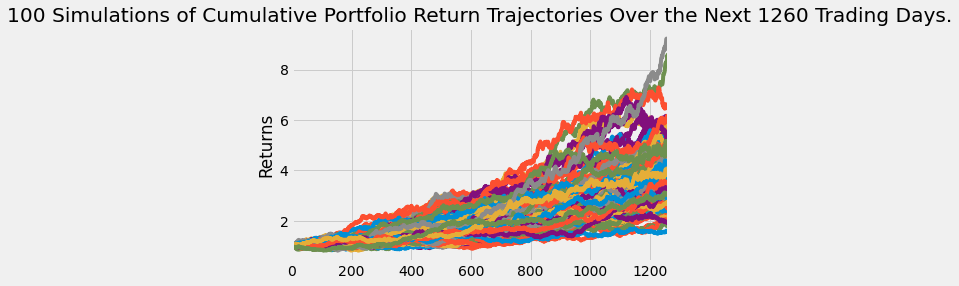

In [29]:
monte_c = simulation.plot_simulation()
monte_c = monte_c.set_ylabel("Returns")
monte_c